# Conservative-to-Primitive Variable Transformation using Physics-Informed Neural Networks
# Clean implementation with improved architecture and training

In [61]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split

# Physics modules (assuming these are available)
from metric import metric
from hybrid_eos import hybrid_eos

# Set up device and precision
use_fp64 = True
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dtype = torch.float64 if use_fp64 else torch.float32

print(f"Using device: {device}")
print(f"Using precision: {dtype}")

Using device: cuda
Using precision: torch.float64


In [62]:
# =============================================================================
# PHYSICS SETUP
# =============================================================================

# Minkowski metric 
eta = metric(
    torch.eye(3, device=device), 
    torch.zeros(3, device=device), 
    torch.ones(1, device=device)
)

# Gamma = 2 EOS with ideal gas thermal contribution 
eos = hybrid_eos(100, 2, 1.8)

In [63]:
def init_weights(m):
    """Xavier initialization for better training stability"""
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)

def W__z(z):
    """Lorentz factor from z"""
    return torch.sqrt(1 + z**2)

def rho__z(z, C):
    """Density from z and conservative variables"""
    return C[:, 0:1] / W__z(z)

def eps__z(z, C):
    """Specific internal energy from z and conservative variables"""
    q = C[:, 1:2]
    r = C[:, 2:3]
    W = W__z(z)
    return W * q - z * r + z**2 / (1 + W)

def a__z(z, C, eos):
    """Specific enthalpy ratio from z and conservative variables"""
    eps = eps__z(z, C)
    rho = rho__z(z, C)
    press = eos.press__eps_rho(eps, rho)
    return press / (rho * (1 + eps))

def h__z(z, C, eos):
    """Specific enthalpy from z and conservative variables"""
    eps = eps__z(z, C)
    a = a__z(z, C, eos)
    return (1 + eps) * (1 + a)

def sanity_check(Z, C, metric, eos):
    """Physics consistency check"""
    t, q, r = torch.split(C, [1, 1, 1], dim=1)
    htilde = h__z(Z, C, eos)
    return torch.mean((Z - r / htilde)**2)

def prims_to_cons(rho, W, metric):
    """
    Generate conservative variables for cold matter
    """
    # Cold matter (T = 0)
    T = torch.zeros_like(rho, device=device)
    
    # EOS call
    press, eps = eos.press_eps__temp_rho(T, rho)

    if torch.isnan(press).any() or torch.isnan(eps).any():
        press = torch.where(torch.isnan(press), torch.tensor(0.0), press)
        eps = torch.where(torch.isnan(eps), torch.tensor(0.0), eps)


    
    # Compute primitive z
    Z = torch.sqrt(1 - 1/W**2) * W 
    
    # Compute conservative variables
    sqrtg = metric.sqrtg 
    u0 = W / sqrtg 
    dens = sqrtg * W * rho 
    
    rho0_h = rho * (1 + eps) + press 
    g4uptt = -1 / metric.alp**2 
    Tuptt = rho0_h * u0**2 + press * g4uptt 
    tau = metric.alp**2 * sqrtg * Tuptt - dens 
    
    S = torch.sqrt((W**2 - 1)) * rho0_h * W
    
    # Assemble conservative variables: [D, tau/D, S/D]
    C = torch.cat((
        dens.view(-1, 1) / metric.sqrtg,
        tau.view(-1, 1) / dens.view(-1, 1),
        S.view(-1, 1) / dens.view(-1, 1)
    ), dim=1)
    
    return C, Z.view(-1, 1)

# =============================================================================
# DATA GENERATION
# =============================================================================

def setup_initial_state_meshgrid_cold(metric, eos, N, device, 
                                      lrhomin=-12, lrhomax=-2.8, 
                                      Wmin=1.0, Wmax=2.0):
    """
    Generate conservative variables on a cold matter meshgrid
    """
    # Create meshgrid
    W = torch.linspace(Wmin, Wmax, N, device=device)
    rho = 10**(torch.linspace(lrhomin, lrhomax, N, device=device))
    
    rho_mesh, W_mesh = torch.meshgrid(rho, W, indexing='ij')
    
    # Flatten
    rho = rho_mesh.flatten()
    W = W_mesh.flatten() 
    
    # Cold matter (T = 0)
    T = torch.zeros_like(rho, device=device)
    
    # EOS call
    press, eps = eos.press_eps__temp_rho(T, rho)
    print(eps)
    
    # Compute primitive z
    Z = torch.sqrt(1 - 1/W**2) * W 
    
    # Compute conservative variables
    sqrtg = metric.sqrtg 
    u0 = W / sqrtg 
    dens = sqrtg * W * rho 
    
    rho0_h = rho * (1 + eps) + press 
    g4uptt = -1 / metric.alp**2 
    Tuptt = rho0_h * u0**2 + press * g4uptt 
    tau = metric.alp**2 * sqrtg * Tuptt - dens 
    
    S = torch.sqrt((W**2 - 1)) * rho0_h * W
    
    # Assemble conservative variables: [D, tau/D, S/D]
    C = torch.cat((
        dens.view(-1, 1) / metric.sqrtg,
        tau.view(-1, 1) / dens.view(-1, 1),
        S.view(-1, 1) / dens.view(-1, 1)
    ), dim=1)
    
    return C, Z.view(-1, 1)


In [64]:
# =============================================================================
# DATASET CLASS
# =============================================================================

class C2P_Dataset(TensorDataset):
    """Dataset class with normalization capabilities"""
    
    def __init__(self, C, Z, normalize_data=True):
        self.C = C.to(dtype)
        self.Z = Z.to(dtype)
        
        if normalize_data:
            self.normalize()
        
    def normalize(self):
        """Min-max normalization"""
        self.C_max = torch.max(self.C, dim=0, keepdim=True)[0]
        self.C_min = torch.min(self.C, dim=0, keepdim=True)[0]
        self.C = (self.C - self.C_min) / (self.C_max - self.C_min)
        
        self.Z_max = torch.max(self.Z, dim=0, keepdim=True)[0]
        self.Z_min = torch.min(self.Z, dim=0, keepdim=True)[0]
        self.Z = (self.Z - self.Z_min) / (self.Z_max - self.Z_min)
    
    def denormalize(self):
        """Reverse normalization"""
        self.C = self.C * (self.C_max - self.C_min) + self.C_min
        self.Z = self.Z * (self.Z_max - self.Z_min) + self.Z_min
    
    def __len__(self):
        return self.C.shape[0]

    def __getitem__(self, idx):
        return self.C[idx, :], self.Z[idx, :]

In [65]:
class ResidualBlock(nn.Module):
    """Residual block with skip connection"""
    
    def __init__(self, in_dim, out_dim, activation, dtype=torch.float64):
        super().__init__()
        self.linear1 = nn.Linear(in_dim, out_dim, dtype=dtype)
        self.linear2 = nn.Linear(out_dim, out_dim, dtype=dtype)
        self.activation = activation
        
        # Skip connection (projection if dimensions don't match)
        if in_dim != out_dim:
            self.skip = nn.Linear(in_dim, out_dim, dtype=dtype)
        else:
            self.skip = nn.Identity()
    
    def forward(self, x):
        identity = self.skip(x)
        out = self.activation(self.linear1(x))
        out = self.linear2(out)
        return self.activation(out + identity)

class C2P_PINN(nn.Module):
    """
    Physics-Informed Neural Network for conservative-to-primitive transformation
    """
    
    def __init__(self, dtype=torch.float64, physics_weight=1.0):
        super().__init__()
        self.input_dim = 3
        self.hidden_dims = [64, 64, 64, 32]
        self.activation = nn.SiLU()
        self.physics_weight = physics_weight
        
        # Define residual blocks
        layers = []
        in_dim = self.input_dim
        for out_dim in self.hidden_dims:
            layers.append(ResidualBlock(in_dim, out_dim, self.activation, dtype))
            in_dim = out_dim
        
        self.blocks = nn.Sequential(*layers)
        
        # Final layer with skip connection from original input
        self.final_fc = nn.Linear(self.hidden_dims[-1] + self.input_dim, 1, dtype=dtype)
        
        # Ensure positive output (physical constraint)
        self.output_activation = nn.Sigmoid()
        
        # Apply weight initialization
        self.apply(init_weights)
    
    def forward(self, x):
        """Forward pass with residual connections"""
        identity = x  # Keep original input for skip connection
        x = self.blocks(x)
        x = torch.cat([x, identity], dim=1)  # Concatenate with original input
        x = self.final_fc(x)
        return self.output_activation(x)
    
    def physics_loss(self, C, Z_pred, eos):
        """
        Physics-informed loss based on relativistic hydro constraints
        """
        # Your conservative variables are [D, τ/D, S/D]
        # The main physics constraint is the sanity check: Z = S/h̃
        
        # Convert back to physical conservative variables
        D = C[:, 0:1]  # Conserved density
        q = C[:, 1:2]  # τ/D 
        r = C[:, 2:3]  # S/D
        
        # Compute specific enthalpy from Z prediction
        try:
            htilde = h__z(Z_pred, C, eos)
            # Physics constraint: Z should equal r/htilde
            physics_residual = Z_pred - r / htilde
            return torch.mean(physics_residual**2)
        except:
            # If physics calculation fails, return zero loss
            return torch.tensor(0.0, device=C.device, dtype=C.dtype)


# Advanced PINN Implementation
# All operations use PyTorch tensors to maintain gradient flow

# =============================================================================
# FOURIER FEATURES (RECOMMENDED FOR YOUR PROBLEM)
# =============================================================================

class FourierPINN(nn.Module):
    """
    Fourier feature PINN with all tensor operations
    Best for complex rootfinding problems like C2P
    """
    def __init__(self, num_fourier_features=128, fourier_sigma=10.0, physics_weight=1.0, dtype=torch.float64):
        super().__init__()
        
        # Store constants as tensors
        self.register_buffer('two_pi', torch.tensor(2.0 * torch.pi, dtype=dtype))
        
        # Random Fourier feature matrix (fixed during training)
        fourier_matrix = torch.randn(3, num_fourier_features, dtype=dtype) * fourier_sigma
        self.register_buffer('fourier_B', fourier_matrix)
        self.physics_weight = physics_weight
        
        # Main network processes Fourier features
        fourier_dim = 2 * num_fourier_features  # sin + cos
        
        self.network = nn.Sequential(
            nn.Linear(fourier_dim, 512, dtype=dtype),
            nn.SiLU(),
            nn.Linear(512, 512, dtype=dtype), 
            nn.SiLU(),
            nn.Linear(512, 256, dtype=dtype),
            nn.SiLU(),
            nn.Linear(256, 128, dtype=dtype),
            nn.SiLU(),
            nn.Linear(128, 1, dtype=dtype),
            nn.Softplus()
        )
        
        # Initialize weights
        self.apply(self._init_weights)
    
    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            # Xavier initialization scaled for SiLU
            nn.init.xavier_uniform_(m.weight, gain=1.0)
            if m.bias is not None:
                nn.init.zeros_(m.bias)
    
    def forward(self, x):
        # Fourier feature mapping: [sin(2πBx), cos(2πBx)]
        x_proj = self.two_pi * (x @ self.fourier_B)  # All tensor operations
        fourier_features = torch.cat([
            torch.sin(x_proj), 
            torch.cos(x_proj)
        ], dim=-1)
        
        return self.network(fourier_features)

    def physics_loss(self, C, Z_pred, eos):
        """
        Physics-informed loss: Z = S / h̃, where h̃ is derived from Z_pred
        """
        D = C[:, 0:1]  # Conserved density
        q = C[:, 1:2]  # τ/D
        r = C[:, 2:3]  # S/D
    
        try:
            # Compute specific enthalpy from prediction
            htilde = h__z(Z_pred, C, eos)
            
            # Physics residual: should be zero if physically correct
            residual = Z_pred - (r / htilde)
            return torch.mean(residual**2)
        
        except Exception as e:
            print(f"[physics_loss] Failed to compute htilde: {e}")
            # Return dummy loss with gradient support
            return torch.sum(Z_pred * 0.0)


# =============================================================================
# MULTI-SCALE NETWORK
# =============================================================================

class MultiScalePINN(nn.Module):
    """
    Multi-scale network with tensor-safe operations
    """
    def __init__(self, dtype=torch.float64):
        super().__init__()
        # Input embedding
        self.input_embed = nn.Linear(3, 128, dtype=dtype)
        
        # Multiple scale pathways
        self.scale1_layers = nn.ModuleList([
            nn.Linear(128, 128, dtype=dtype) for _ in range(3)
        ])
        
        self.scale2_layers = nn.ModuleList([
            nn.Linear(128, 64, dtype=dtype),
            nn.Linear(64, 128, dtype=dtype)
        ])
        
        self.scale3_layers = nn.ModuleList([
            nn.Linear(128, 256, dtype=dtype),
            nn.Linear(256, 128, dtype=dtype)
        ])
        
        # Attention for scale combination - FIXED
        self.scale_attention = nn.Sequential(
            nn.Linear(128, 64, dtype=dtype),
            nn.SiLU(),
            nn.Linear(64, 3, dtype=dtype),
            nn.Softmax(dim=-1)
        )
        
        # Output with skip connection - FIXED
        self.output_layer = nn.Sequential(
            nn.Linear(128 + 3, 64, dtype=dtype),  # +3 for input skip
            nn.SiLU(),
            nn.Linear(64, 1, dtype=dtype),
            nn.Softplus()
        )
        
        self.apply(self._init_weights)
    
    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.zeros_(m.bias)
    
    def forward(self, x):
        identity = x
        
        # Input embedding - FIXED
        h = F.silu(self.input_embed(x))
        
        # Scale 1: Standard pathway - FIXED
        h1 = h
        for layer in self.scale1_layers:
            h1 = F.silu(layer(h1))
        h1 = h1 + h  # Residual
        
        # Scale 2: Compressed pathway - FIXED
        h2 = h
        for layer in self.scale2_layers:
            h2 = F.silu(layer(h2))
        h2 = h2 + h  # Residual
        
        # Scale 3: Expanded pathway - FIXED
        h3 = h
        for layer in self.scale3_layers:
            h3 = F.silu(layer(h3))
        h3 = h3 + h  # Residual
        
        # Attention-based combination
        attention_weights = self.scale_attention(h)  # [batch, 3]
        combined = (attention_weights[:, 0:1] * h1 +
                   attention_weights[:, 1:2] * h2 +
                   attention_weights[:, 2:3] * h3)
        
        # Output with global skip connection
        output_input = torch.cat([combined, identity], dim=-1)
        return self.output_layer(output_input)
    
    def physics_loss(self, C, Z_pred, eos):
        """
        Physics-informed loss: Z = S / h̃, where h̃ is derived from Z_pred
        """
        D = C[:, 0:1]  # Conserved density
        q = C[:, 1:2]  # τ/D
        r = C[:, 2:3]  # S/D
        
        try:
            # Compute specific enthalpy from prediction
            htilde = h__z(Z_pred, C, eos)
            
            # Physics residual: should be zero if physically correct
            residual = Z_pred - (r / htilde)
            return torch.mean(residual**2)
        
        except Exception as e:
            print(f"[physics_loss] Failed to compute htilde: {e}")
            # Return dummy loss with gradient support
            return torch.sum(Z_pred * 0.0)

# =============================================================================
# RESIDUAL NETWORK (ENHANCED VERSION OF YOUR CURRENT)
# =============================================================================

class DeepResidualPINN(nn.Module):
    """
    Deep residual network - enhanced version of your current architecture
    """
    def __init__(self, depth=8, width=128, dtype=torch.float64):
        super().__init__()
        
        # Input projection
        self.input_layer = nn.Linear(3, width, dtype=dtype)
        
        # Deep residual blocks
        self.residual_blocks = nn.ModuleList()
        for _ in range(depth):
            block = nn.ModuleList([
                nn.Linear(width, width, dtype=dtype),
                nn.Linear(width, width, dtype=dtype)
            ])
            self.residual_blocks.append(block)
        
        # Output with multiple skip connections
        self.output_layer = nn.Sequential(
            nn.Linear(width + 3, width // 2, dtype=dtype),  # Global skip
            nn.SiLU(),
            nn.Linear(width // 2, 1, dtype=dtype),
            nn.Softplus()
        )
        
        self.apply(self._init_weights)
    
    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            # He initialization for SiLU activation
            nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
            if m.bias is not None:
                nn.init.zeros_(m.bias)
    
    def forward(self, x):
        identity = x
        
        # Input embedding - FIXED
        h = F.silu(self.input_layer(x))
        
        # Deep residual processing
        for block in self.residual_blocks:
            # Pre-activation residual block
            residual = h
            h = F.silu(block[0](h))  # FIXED
            h = block[1](h)
            h = h + residual  # Residual connection
            h = F.silu(h)  # Post-activation - FIXED
        
        # Global skip connection to output
        output_input = torch.cat([h, identity], dim=-1)
        return self.output_layer(output_input)

    def physics_loss(self, C, Z_pred, eos):
        """
        Physics-informed loss: Z = S / h̃, where h̃ is derived from Z_pred
        """
        D = C[:, 0:1]  # Conserved density
        q = C[:, 1:2]  # τ/D
        r = C[:, 2:3]  # S/D
        
        try:
            # Compute specific enthalpy from prediction
            htilde = h__z(Z_pred, C, eos)
            
            # Physics residual: should be zero if physically correct
            residual = Z_pred - (r / htilde)
            return torch.mean(residual**2)
        
        except Exception as e:
            print(f"[physics_loss] Failed to compute htilde: {e}")
            # Return dummy loss with gradient support
            return torch.sum(Z_pred * 0.0)

In [66]:
# =============================================================================
# LOSS FUNCTIONS
# =============================================================================

def log_cosh_loss(y_true, y_pred):
    """Robust loss function that's less sensitive to outliers"""
    return torch.mean(torch.log(torch.cosh(y_pred - y_true)))

def huber_loss(y_true, y_pred, delta=1.0):
    """Huber loss for robust regression"""
    residual = torch.abs(y_true - y_pred)
    condition = residual <= delta
    squared_loss = 0.5 * (y_true - y_pred)**2
    linear_loss = delta * residual - 0.5 * delta**2
    return torch.mean(torch.where(condition, squared_loss, linear_loss))

def compute_loss(model, C, C_min, C_max, Z, Z_min, Z_max, eos=None, 
                physics_weight=1.0, loss_type='log_cosh'):
    """
    Compute combined data loss and physics loss
    """
    # Forward pass
    Z_pred = model(C)
    
    # Data fitting loss
    if loss_type == 'log_cosh':
        data_loss = log_cosh_loss(Z, Z_pred)
    elif loss_type == 'huber':
        data_loss = huber_loss(Z, Z_pred)
    elif loss_type == 'mse':
        data_loss = nn.MSELoss()(Z_pred, Z)
    else:
        data_loss = log_cosh_loss(Z, Z_pred)
    
    # Physics loss (if model supports it and parameters provided)
    physics_loss = 0.0
    if hasattr(model, 'physics_loss') and eos is not None:
        # Convert normalized inputs back to physical units for physics loss
        C_real = C * (C_max - C_min) + C_min
        Z_real = Z_pred * (Z_max - Z_min) + Z_min
        physics_loss = model.physics_loss(C_real, Z_real, eos)
    
    # Combined loss
    total_loss = data_loss + physics_weight * physics_loss
    
    return total_loss, data_loss, physics_loss

def compute_validation_loss(model, C, C_min, C_max, Z, Z_min, Z_max, eos):
    """
    Compute validation metrics including physical consistency checks
    """
    with torch.no_grad():
        Z_pred = model(C)
        
        # Convert back to physical units
        Z_pred_real = Z_pred * (Z_max - Z_min) + Z_min
        Z_real = Z * (Z_max - Z_min) + Z_min
        C_real = C * (C_max - C_min) + C_min
        
        # Physics consistency check
        err = sanity_check(Z_pred_real, C_real, eta, eos)
        
        return err

In [67]:
# =============================================================================
# TRAINING FUNCTION
# =============================================================================

def train_pinn_model(model, optimizer, scheduler, training_loader, validation_loader,
                     C_min, C_max, Z_min, Z_max, num_epochs, eos, 
                     physics_weight=0.1, loss_type='log_cosh',
                     device='cpu', patience=50):
    """
    Train PINN model with comprehensive logging and early stopping
    """
    
    # Move model to device
    model = model.to(device)
    
    # Training history
    training_losses = []
    validation_losses = []
    physics_losses = []
    
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None
    
    print(f"Training PINN for {num_epochs} epochs...")
    print(f"Physics weight: {physics_weight}, Loss type: {loss_type}")
    print("-" * 60)
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        epoch_loss = 0
        epoch_physics_loss = 0
        
        for batch_idx, (C_data, Z_data) in enumerate(training_loader):
            C_data, Z_data = C_data.to(device), Z_data.to(device)
            
            optimizer.zero_grad()
            
            # Compute loss
            total_loss, data_loss, phys_loss = compute_loss(
                model, C_data, C_min, C_max, Z_data, Z_min, Z_max,
                eos, physics_weight, loss_type
            )
            
            # Backward pass
            total_loss.backward()
            
            # Gradient clipping for stability
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            
            # Accumulate losses
            epoch_loss += total_loss.item()
            if isinstance(phys_loss, torch.Tensor):
                epoch_physics_loss += phys_loss.item()
        
        # Average losses
        epoch_loss /= len(training_loader)
        epoch_physics_loss /= len(training_loader)
        
        # Validation phase
        model.eval()
        val_loss = 0
        
        with torch.no_grad():
            for C_test, Z_test in validation_loader:
                C_test, Z_test = C_test.to(device), Z_test.to(device)
                
                val_err = compute_validation_loss(
                    model, C_test, C_min, C_max, Z_test, Z_min, Z_max, eos
                )
                
                val_loss += val_err.item()
        
        val_loss /= len(validation_loader)
        
        # Store history
        training_losses.append(epoch_loss)
        validation_losses.append(val_loss)
        physics_losses.append(epoch_physics_loss)
        
        # Learning rate scheduling
        if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
            scheduler.step(val_loss)
        else:
            scheduler.step()
        
        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            best_model_state = model.state_dict().copy()
        else:
            patience_counter += 1
        
        # Print progress
        if epoch % 10 == 0:
            current_lr = optimizer.param_groups[0]['lr']
            print(f"Epoch {epoch:4d} | "
                  f"Train Loss: {epoch_loss:.3e} | "
                  f"Val Loss: {val_loss:.3e} | "
                  f"Physics: {epoch_physics_loss:.3e} | "
                  f"LR: {current_lr:.2e}")
        
        # Early stopping check
        if patience_counter >= patience:
            print(f"\nEarly stopping triggered at epoch {epoch}")
            break
    
    # Load best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print(f"Loaded best model with validation loss: {best_val_loss:.3e}")
    
    return {
        'training_losses': training_losses,
        'validation_losses': validation_losses,
        'physics_losses': physics_losses,
        'best_val_loss': best_val_loss
    }

# =============================================================================
# 6. ADVANCED TRAINING TECHNIQUES
# =============================================================================

class CyclicLR(torch.optim.lr_scheduler._LRScheduler):
    """
    Cyclic learning rate for escaping local minima
    """
    def __init__(self, optimizer, base_lr=1e-6, max_lr=1e-3, step_size=100):
        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        super().__init__(optimizer)
    
    def get_lr(self):
        cycle = torch.floor(1 + self.last_epoch / (2 * self.step_size))
        x = torch.abs(self.last_epoch / self.step_size - 2 * cycle + 1)
        lr = self.base_lr + (self.max_lr - self.base_lr) * torch.maximum(0, (1 - x))
        return [lr for _ in self.base_lrs]

In [68]:
class C2P_Solver:
    """Conservative-to-primitive variable solver using trained PINN"""
    
    def __init__(self, model, eos, C_min, C_max, Z_min, Z_max, device='cpu'):
        self.model = model

        self.C_min = torch.tensor(C_min, device=device, dtype=torch.float64)
        self.C_max = torch.tensor(C_max, device=device, dtype=torch.float64)
        self.Z_min = torch.tensor(Z_min, device=device, dtype=torch.float64)
        self.Z_max = torch.tensor(Z_max, device=device, dtype=torch.float64)
        self.eos = eos 

        self.model.eval()

    
    def invert(self, C):
        """
        Invert conservative variables to primitive variables
        """
        with torch.no_grad():
            # Ensure C is on the same device
            if not isinstance(C, torch.Tensor):
                print("not instance of torch.Tensor, converting...")
                C = torch.tensor(C, device=self.C_min.device, dtype=torch.float64)

            # Normalize input
            C_norm = (C - self.C_min) / (self.C_max - self.C_min)
            
            # Predict normalized Z
            Z_norm = self.model(C_norm)
            
            # Denormalize Z
            Z = Z_norm * (self.Z_max - self.Z_min) + self.Z_min
        
            # Compute primitive variables
            rho = rho__z(Z, C)
            W = W__z(Z)
            eps = eps__z(Z, C)
            press = self.eos.press__eps_rho(eps, rho)
            
            # Cold matter (T = 0)
            T = torch.zeros_like(rho, device=device)

            # EOS call
            press, eps = eos.press_eps__temp_rho(T, rho)

            return rho, eps, press, W


In [69]:
def plot_training_history(history):
    """Plot training curves for analysis"""
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # Training and validation loss
    axes[0, 0].semilogy(history['training_losses'], label='Training Loss')
    axes[0, 0].semilogy(history['validation_losses'], label='Validation Loss')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].set_title('Training and Validation Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True)
    
    # Physics loss
    axes[0, 1].semilogy(history['physics_losses'])
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Physics Loss')
    axes[0, 1].set_title('Physics-Informed Loss')
    axes[0, 1].grid(True)
    
    # Loss components comparison
    axes[1, 0].semilogy(history['training_losses'], label='Total Loss')
    axes[1, 0].semilogy(history['physics_losses'], label='Physics Loss')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Loss')
    axes[1, 0].set_title('Loss Components')
    axes[1, 0].legend()
    axes[1, 0].grid(True)
    
    # Convergence analysis
    min_loss = min(history['validation_losses'])
    axes[1, 1].semilogy([min_loss] * len(history['validation_losses']), 
                        '--', label=f'Best Val Loss: {min_loss:.2e}')
    axes[1, 1].semilogy(history['validation_losses'], label='Validation Loss')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Loss')
    axes[1, 1].set_title('Convergence Analysis')
    axes[1, 1].legend()
    axes[1, 1].grid(True)
    
    plt.tight_layout()
    plt.show()

def plot_error_analysis(solver, test_C, test_Z, N=50):
    """Plot comprehensive error analysis"""
    
    # Predict on test data
    rho_pred, eps_pred, press_pred, W_pred = solver.invert(test_C)
    
    # Compute true values
    Z_true = test_Z.view(-1, 1)
    rho_true = rho__z(Z_true, test_C)
    W_true = W__z(Z_true)
    eps_true = eps__z(Z_true, test_C)
    press_true = solver.eos.press__eps_rho(eps_true, rho_true)
    
    # Calculate relative errors
    rho_error = torch.abs(rho_pred - rho_true) / rho_true
    eps_error = torch.abs(eps_pred - eps_true) / (eps_true + 1e-10)
    press_error = torch.abs(press_pred - press_true) / (press_true + 1e-10)
    W_error = torch.abs(W_pred - W_true) / W_true
    
    # Convert to numpy for plotting
    errors = {
        'Density': rho_error.cpu().numpy().flatten(),
        'Specific Energy': eps_error.cpu().numpy().flatten(), 
        'Pressure': press_error.cpu().numpy().flatten(),
        'Lorentz Factor': W_error.cpu().numpy().flatten()
    }
    
    # Create error distribution plots
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.flatten()
    
    for i, (name, error) in enumerate(errors.items()):
        axes[i].hist(torch.log10(error + 1e-15), bins=50, alpha=0.7)
        axes[i].set_xlabel('log10(Relative Error)')
        axes[i].set_ylabel('Frequency')
        axes[i].set_title(f'{name} Error Distribution')
        axes[i].grid(True)
        
        # Add statistics
        mean_error = torch.mean(error)
        max_error = torch.max(error)
        axes[i].axvline(torch.log10(mean_error), color='r', linestyle='--', 
                       label=f'Mean: {mean_error:.2e}')
        axes[i].axvline(torch.log10(max_error), color='orange', linestyle='--', 
                       label=f'Max: {max_error:.2e}')
        axes[i].legend()
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("Error Analysis Summary:")
    print("-" * 40)
    for name, error in errors.items():
        print(f"{name:15s}: Mean={torch.mean(error):.2e}, Max={torch.max(error):.2e}")


In [70]:
C, Z = setup_initial_state_meshgrid_cold(eta, eos, 50, device, Wmin=1.2, Wmax=1.8)
err = sanity_check(Z, C, eta, eos)
print(f"Initial sanity check error: {err:.2e}")
dataset = C2P_Dataset(C, Z)
    
# Split into train/validation
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create data loaders
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Create model
model = C2P_PINN(dtype=dtype, physics_weight=0.1)
#model = FourierPINN(dtype=dtype)
model = model.to(device)

# Setup optimizer and scheduler
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5, verbose=True
)


tensor([1.0000e-10, 1.0000e-10, 1.0000e-10,  ..., 1.5849e-01, 1.5849e-01,
        1.5849e-01], device='cuda:0')
Initial sanity check error: 8.08e-14


In [71]:
history = train_pinn_model(
        model=model,
        optimizer=optimizer,
        scheduler=scheduler,
        training_loader=train_loader,
        validation_loader=val_loader,
        C_min=dataset.C_min,
        C_max=dataset.C_max,
        Z_min=dataset.Z_min,
        Z_max=dataset.Z_max,
        num_epochs=50,
        eos=eos,
        physics_weight=0.1,
        loss_type='log_cosh',
        device=device,
        patience=50
    )

Training PINN for 50 epochs...
Physics weight: 0.1, Loss type: log_cosh
------------------------------------------------------------
Epoch    0 | Train Loss: 3.597e-02 | Val Loss: 3.421e-02 | Physics: 4.562e-02 | LR: 1.00e-03
Epoch   10 | Train Loss: 4.290e-04 | Val Loss: 4.602e-04 | Physics: 5.157e-04 | LR: 1.00e-03
Epoch   20 | Train Loss: 5.856e-05 | Val Loss: 6.148e-05 | Physics: 6.984e-05 | LR: 1.00e-03
Epoch   30 | Train Loss: 5.573e-05 | Val Loss: 5.741e-05 | Physics: 6.663e-05 | LR: 1.00e-03
Epoch   40 | Train Loss: 5.265e-05 | Val Loss: 5.634e-05 | Physics: 6.315e-05 | LR: 1.00e-03
Loaded best model with validation loss: 4.904e-05


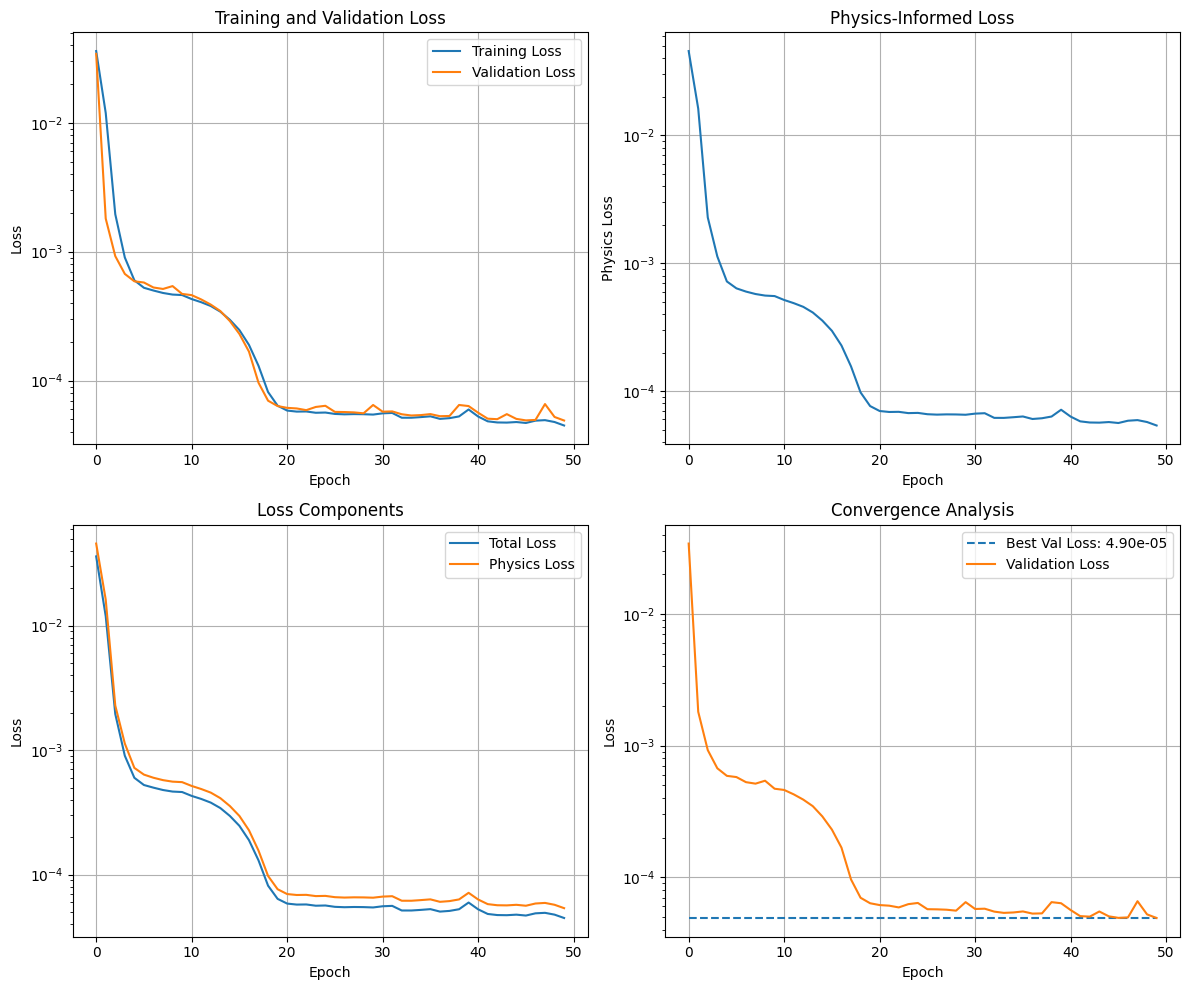

In [72]:
# Plot training results
plot_training_history(history)


In [73]:
solver = C2P_Solver(
    model,
    eos,
    C_min=C.min().item(),
    C_max=C.max().item(),
    Z_min=Z.min().item(),
    Z_max=Z.max().item(),
    device=device
)
# Generate test data
test_C, test_Z = setup_initial_state_meshgrid_cold(eta, eos, 50, device, Wmin=1.2, Wmax=1.8)
test_dataset = C2P_Dataset(test_C, test_Z)#, normalize_data=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)
model.to(device)

tensor([1.0000e-10, 1.0000e-10, 1.0000e-10,  ..., 1.5849e-01, 1.5849e-01,
        1.5849e-01], device='cuda:0')


C2P_PINN(
  (activation): SiLU()
  (blocks): Sequential(
    (0): ResidualBlock(
      (linear1): Linear(in_features=3, out_features=64, bias=True)
      (linear2): Linear(in_features=64, out_features=64, bias=True)
      (activation): SiLU()
      (skip): Linear(in_features=3, out_features=64, bias=True)
    )
    (1): ResidualBlock(
      (linear1): Linear(in_features=64, out_features=64, bias=True)
      (linear2): Linear(in_features=64, out_features=64, bias=True)
      (activation): SiLU()
      (skip): Identity()
    )
    (2): ResidualBlock(
      (linear1): Linear(in_features=64, out_features=64, bias=True)
      (linear2): Linear(in_features=64, out_features=64, bias=True)
      (activation): SiLU()
      (skip): Identity()
    )
    (3): ResidualBlock(
      (linear1): Linear(in_features=64, out_features=32, bias=True)
      (linear2): Linear(in_features=32, out_features=32, bias=True)
      (activation): SiLU()
      (skip): Linear(in_features=64, out_features=32, bias=True)

In [82]:
# Before calling solver.invert()
test_C = test_dataset.C  # Convert to float64 to match model
primitives = solver.invert(test_dataset.C) # returns (rho, eps, press, W)
C_from_prims = prims_to_cons(primitives[0], primitives[3], eta)
print("C_from_prims" , C_from_prims) # Get the first batch for comparison
print("test_C", test_C) # Get the first batch for comparison

C_from_prims (tensor([[0.0000e+00,        nan,        nan],
        [4.2922e-12, 2.1604e-01, 6.9192e-01],
        [8.5844e-12, 2.1905e-01, 6.9720e-01],
        ...,
        [9.8639e-01, 1.5340e+02, 1.4744e+02],
        [9.9320e-01, 1.5479e+02, 1.4889e+02],
        [1.0000e+00, 1.5617e+02, 1.5035e+02]], device='cuda:0',
       dtype=torch.float64), tensor([[0.6872],
        [0.6919],
        [0.6972],
        ...,
        [1.1059],
        [1.1133],
        [1.1207]], device='cuda:0', dtype=torch.float64))
test_C tensor([[0.0000e+00, 2.7531e-08, 4.5578e-08],
        [4.2922e-12, 1.1312e-02, 1.6749e-02],
        [8.5844e-12, 2.2623e-02, 3.3141e-02],
        ...,
        [9.8639e-01, 9.6908e-01, 9.7025e-01],
        [9.9320e-01, 9.8455e-01, 9.8515e-01],
        [1.0000e+00, 1.0000e+00, 1.0000e+00]], device='cuda:0',
       dtype=torch.float64)


In [75]:
import torch
import numpy as np

def comprehensive_error_analysis(test_C, C_model, test_P=None, P_model=None, inversion_flags=None):
    """
    Comprehensive error analysis for SRMHD conservative-to-primitive inverter validation.
    
    Args:
        test_C (Tensor): Ground truth conservative variables [D, tau/D, Sx/D, ...]
        C_model (Tensor): Predicted conservative variables (from model)
        test_P (Tensor, optional): Ground truth primitive variables [rho, v_i, p, B_i]
        P_model (Tensor, optional): Predicted primitive variables (via c2p inverter)
        inversion_flags (Tensor[bool], optional): Tensor indicating whether c2p succeeded (True) or failed (False)
    
    Returns:
        Dictionary containing detailed error metrics and diagnostics
    """
    
    # Input validation
    if test_C.shape != C_model.shape:
        raise ValueError(f"Shape mismatch: test_C {test_C.shape} vs C_model {C_model.shape}")
    
    if test_P is not None and P_model is not None:
        if test_P.shape != P_model.shape:
            raise ValueError(f"Shape mismatch: test_P {test_P.shape} vs P_model {P_model.shape}")
    
    # Ensure both tensors are aligned
    C_model = C_model.to(test_C.device).to(test_C.dtype)
    
    # Handle potential NaN/Inf values
    test_C_clean = torch.where(torch.isfinite(test_C), test_C, torch.zeros_like(test_C))
    C_model_clean = torch.where(torch.isfinite(C_model), C_model, torch.zeros_like(C_model))
    
    abs_error = torch.abs(test_C_clean - C_model_clean)
    rel_error = abs_error / (torch.abs(test_C_clean) + 1e-15)
    
    # More descriptive variable names
    var_names = ['D (Density)', 'tau/D (Energy)', 'Sx/D (Momentum X)', 
                 'Sy/D (Momentum Y)', 'Sz/D (Momentum Z)', 'Bx (Magnetic X)', 
                 'By (Magnetic Y)', 'Bz (Magnetic Z)'][:test_C.shape[1]]
    
    print("=" * 80)
    print("🔬 SRMHD C2P INVERTER VALIDATION - COMPREHENSIVE ERROR ANALYSIS")
    print("=" * 80)
    
    results = {}
    
    # --------------------------
    # 1. OVERALL STATISTICS
    # --------------------------
    print("\n📊 1. OVERALL ERROR STATISTICS:")
    print("-" * 50)
    
    total_abs_error = torch.sum(abs_error)
    total_rel_error = torch.mean(rel_error)
    rmse_total = torch.sqrt(torch.mean((test_C_clean - C_model_clean)**2))
    mae_total = torch.mean(abs_error)
    
    print(f"📈 Total Absolute Error (sum):     {total_abs_error:.6e}")
    print(f"📈 Mean Absolute Error (MAE):      {mae_total:.6e}")
    print(f"📈 Root Mean Square Error (RMSE):  {rmse_total:.6e}")
    print(f"📈 Mean Relative Error:            {total_rel_error:.6f} ({total_rel_error*100:.3f}%)")
    
    results.update({
        'total_abs_error': total_abs_error.item(),
        'mae_total': mae_total.item(),
        'rmse_total': rmse_total.item(),
        'mean_rel_error': total_rel_error.item()
    })
    
    # --------------------------
    # 2. PER-VARIABLE ANALYSIS
    # --------------------------
    print("\n🔍 2. PER-VARIABLE ERROR ANALYSIS:")
    print("-" * 50)
    
    for i, var_name in enumerate(var_names):
        print(f"\n🔸 {var_name}:")
        
        test_col = test_C_clean[:, i]
        model_col = C_model_clean[:, i]
        abs_err_col = abs_error[:, i]
        rel_err_col = rel_error[:, i]
        
        mae_var = torch.mean(abs_err_col)
        rmse_var = torch.sqrt(torch.mean((test_col - model_col)**2))
        max_abs_err = torch.max(abs_err_col)
        max_rel_err = torch.max(rel_err_col)
        mean_rel_err = torch.mean(rel_err_col)
        
        test_range = [torch.min(test_col).item(), torch.max(test_col).item()]
        model_range = [torch.min(model_col).item(), torch.max(model_col).item()]
        
        print(f"  📏 Original range:        [{test_range[0]:.6e}, {test_range[1]:.6e}]")
        print(f"  📏 Model range:           [{model_range[0]:.6e}, {model_range[1]:.6e}]")
        print(f"  📈 MAE:                   {mae_var:.6e}")
        print(f"  📈 RMSE:                  {rmse_var:.6e}")
        print(f"  ⚠️  Max absolute error:    {max_abs_err:.6e}")
        print(f"  ⚠️  Max relative error:    {max_rel_err:.6f} ({max_rel_err*100:.3f}%)")
        print(f"  📊 Mean relative error:   {mean_rel_err:.6f} ({mean_rel_err*100:.3f}%)")
        
        # Create safer prefix for results dictionary
        prefix = var_name.split()[0].lower().replace('/', '_').replace('(', '').replace(')', '')
        results.update({
            f'{prefix}_mae': mae_var.item(),
            f'{prefix}_rmse': rmse_var.item(),
            f'{prefix}_max_abs_err': max_abs_err.item(),
            f'{prefix}_max_rel_err': max_rel_err.item(),
            f'{prefix}_mean_rel_err': mean_rel_err.item(),
        })
    
    # --------------------------
    # 3. ERROR DISTRIBUTION
    # --------------------------
    print("\n📊 3. ERROR DISTRIBUTION ANALYSIS:")
    print("-" * 50)
    
    rel_error_flat = rel_error.flatten()
    # Remove any remaining NaN/Inf values
    rel_error_flat = rel_error_flat[torch.isfinite(rel_error_flat)]
    
    if len(rel_error_flat) > 0:
        percentiles = [50, 90, 95, 99, 99.9]
        
        print("📈 Relative Error Percentiles:")
        for p in percentiles:
            val = torch.quantile(rel_error_flat, p / 100.0)
            print(f"  {p:4.1f}th percentile: {val:.6f} ({val*100:.3f}%)")
            results[f'rel_error_{p}th_percentile'] = val.item()
        
        bad_thresholds = [0.01, 0.05, 0.1, 0.2]
        print("\n⚠️  Samples with high relative error:")
        total_samples = rel_error_flat.numel()
        
        for thresh in bad_thresholds:
            count = torch.sum(rel_error_flat > thresh).item()
            percentage = count / total_samples * 100 if total_samples > 0 else 0
            print(f"  > {thresh*100:4.1f}%: {count:6d} samples ({percentage:5.2f}% of total)")
            results[f'samples_above_{thresh*100:.0f}pct_error'] = count
    else:
        print("⚠️  No valid samples found for error distribution analysis")
    
    # --------------------------
    # 4. PHYSICAL CONSISTENCY
    # --------------------------
    print("\n🔬 4. PHYSICAL CONSISTENCY:")
    print("-" * 50)
    
    neg_density = torch.sum(C_model_clean[:, 0] < 0).item()
    print(f"⚠️  Negative densities predicted:    {neg_density}")
    results['negative_density'] = neg_density
    
    for i, var_name in enumerate(var_names):
        non_finite = torch.sum(~torch.isfinite(C_model[:, i])).item()
        if non_finite > 0:
            print(f"⚠️  Non-finite values in {var_name}: {non_finite}")
        prefix = var_name.split()[0].lower().replace('/', '_').replace('(', '').replace(')', '')
        results[f'{prefix}_non_finite'] = non_finite
    
    # --------------------------
    # 5. INVERSION FAILURES
    # --------------------------
    if inversion_flags is not None:
        failed_count = torch.sum(~inversion_flags).item()
        success_rate = (len(inversion_flags) - failed_count) / len(inversion_flags) * 100
        print(f"\n💥 Inversion failures:              {failed_count}")
        print(f"✅ Success rate:                   {success_rate:.2f}%")
        results['inversion_failures'] = failed_count
        results['success_rate'] = success_rate
    
    # --------------------------
    # 6. PRIMITIVE VARIABLE CHECKS
    # --------------------------
    if test_P is not None and P_model is not None:
        print("\n🔍 6. PRIMITIVE VARIABLE ERROR:")
        print("-" * 50)
        P_model = P_model.to(test_P.device).to(test_P.dtype)
        
        # Clean primitive variables
        test_P_clean = torch.where(torch.isfinite(test_P), test_P, torch.zeros_like(test_P))
        P_model_clean = torch.where(torch.isfinite(P_model), P_model, torch.zeros_like(P_model))
        
        abs_P_error = torch.abs(test_P_clean - P_model_clean)
        rel_P_error = abs_P_error / (torch.abs(test_P_clean) + 1e-15)
        
        prim_var_names = ['ρ (Density)', 'vₓ (Velocity X)', 'vᵧ (Velocity Y)', 'vᵤ (Velocity Z)', 
                         'p (Pressure)', 'Bₓ (Magnetic X)', 'Bᵧ (Magnetic Y)', 'Bᵤ (Magnetic Z)']
        
        for i in range(test_P.shape[1]):
            var_name = prim_var_names[i] if i < len(prim_var_names) else f'Primitive Var {i}'
            mae_p = torch.mean(abs_P_error[:, i])
            rmse_p = torch.sqrt(torch.mean((test_P_clean[:, i] - P_model_clean[:, i])**2))
            rel_err_p = torch.mean(rel_P_error[:, i])
            print(f"🔸 {var_name}: MAE = {mae_p:.3e}, RMSE = {rmse_p:.3e}, Mean Rel Error = {rel_err_p*100:.3f}%")
            results[f'primitive_{i}_mae'] = mae_p.item()
            results[f'primitive_{i}_rmse'] = rmse_p.item()
            results[f'primitive_{i}_rel_error'] = rel_err_p.item()
        
        # Lorentz factor consistency check (assuming velocities at [1,2,3] of P)
        if test_P.shape[1] >= 4:
            v_model = P_model_clean[:, 1:4]
            v_mag2 = torch.sum(v_model**2, dim=1)
            superluminal = torch.sum(v_mag2 >= 1.0).item()  # Changed to >= for safety
            
            # Safe Lorentz factor calculation
            v_mag2_safe = torch.clamp(v_mag2, max=0.999999)  # Prevent division by zero
            W = 1.0 / torch.sqrt(1 - v_mag2_safe)
            W_invalid = torch.sum(~torch.isfinite(W)).item()
            
            print(f"\n⚠️  Lorentz factor invalid:          {W_invalid}")
            print(f"⚠️  Superluminal velocity samples:   {superluminal}")
            results['superluminal_velocity'] = superluminal
            results['lorentz_invalid'] = W_invalid
    
    # --------------------------
    # 7. SUMMARY
    # --------------------------
    print("\n🎯 7. SUMMARY ASSESSMENT:")
    print("-" * 50)
    
    overall_quality = ("🟢 EXCELLENT" if total_rel_error < 0.01 else 
                      "🟡 GOOD" if total_rel_error < 0.05 else 
                      "🟠 FAIR" if total_rel_error < 0.1 else 
                      "🔴 POOR")
    
    print(f"Overall Model Quality: {overall_quality}")
    print(f"Mean Relative Error:   {total_rel_error*100:.3f}%")
    results['overall_quality'] = overall_quality.split()[1]  # Store without emoji
    
    if len(var_names) > 0:
        worst_var_idx = torch.argmax(torch.mean(rel_error, dim=0))
        worst_var = var_names[worst_var_idx]
        worst_var_error = torch.mean(rel_error[:, worst_var_idx])
        print(f"Most problematic variable: {worst_var} ({worst_var_error*100:.3f}% error)")
        results['worst_variable'] = worst_var
        results['worst_variable_error'] = worst_var_error.item()
    
    if total_rel_error > 0.1:
        print("\n💡 RECOMMENDATIONS:")
        print("   • Consider longer training or different architecture")
        print("   • Check data preprocessing and normalization")
        print("   • Verify loss function and optimization strategy")
        print("   • Investigate physical constraint enforcement")
    
    print("=" * 80)
    return results


def quick_error_summary(test_C, C_model):
    """Quick error summary for training loop usage."""
    # Input validation
    if test_C.shape != C_model.shape:
        raise ValueError(f"Shape mismatch: test_C {test_C.shape} vs C_model {C_model.shape}")
    
    # Ensure same device and dtype
    C_model = C_model.to(test_C.device).to(test_C.dtype)
    
    # Handle NaN/Inf values
    test_C_clean = torch.where(torch.isfinite(test_C), test_C, torch.zeros_like(test_C))
    C_model_clean = torch.where(torch.isfinite(C_model), C_model, torch.zeros_like(C_model))
    
    abs_error = torch.abs(test_C_clean - C_model_clean)
    rel_error = abs_error / (torch.abs(test_C_clean) + 1e-15)
    
    # Filter out non-finite relative errors
    rel_error_finite = rel_error[torch.isfinite(rel_error)]
    
    mae = torch.mean(abs_error)
    rmse = torch.sqrt(torch.mean((test_C_clean - C_model_clean)**2))
    mean_rel_err = torch.mean(rel_error_finite) if len(rel_error_finite) > 0 else torch.tensor(0.0)
    max_rel_err = torch.max(rel_error_finite) if len(rel_error_finite) > 0 else torch.tensor(0.0)
    
    print(f"📊 Quick Summary - MAE: {mae:.6e}, RMSE: {rmse:.6e}, "
          f"Mean Rel Err: {mean_rel_err*100:.3f}%, Max Rel Err: {max_rel_err*100:.3f}%")
    
    return mae.item(), rmse.item(), mean_rel_err.item(), max_rel_err.item()


comprehensive_error_analysis(test_C, C_model, test_P=None, P_model=None, inversion_flags=None)
# Example usage (remove the last 2 lines from the original code):
# print("\nQuick Summary:")
# mae, rmse, mean_rel_err, max_rel_err = quick_error_summary(test_C, C_model)

NameError: name 'C_model' is not defined

In [ ]:
import torch
from torchviz import make_dot

# Create model and dummy input
model = C2P_PINN()
x = torch.randn(1, 3, requires_grad=True,dtype=dtype)  # Batch size 1, 3 inputs

# Forward pass
y = model(x)

# Create visualization
dot = make_dot(y, params=dict(model.named_parameters()), show_attrs=True, show_saved=True)
dot.render("neural_network_graph", format="png")  # Saves as PNG
dot.view()  # Opens the image

'neural_network_graph.pdf'